# AirBnB Listing Analysis
## Analyzing AirBnB listings in Paris to determine the impact of recent regulations


The dataset made available by [Maven Analytics](https://app.mavenanalytics.io/)

You can find the csv file here on [Kaggle](https://www.kaggle.com/datasets/toufikbhm/airbnb-listings-and-reviews)

I uploaded the dataset to BigQuery for the purpose of this project.

# Importing the necessary librairies

In [28]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from kaggle_secrets import UserSecretsClient

# Setting up BigQuery Client and Fetching the AirBnB Dataset

In [29]:
# Adding the project id and dataset id for AirBnB data stored on my BigQuery database
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dataset_id")
secret_value_1 = user_secrets.get_secret("project_id")

In [30]:
# Identify the project ID containing the desired dataset
PROJECT_ID = secret_value_1

# Creating the BQ API Client
client = bigquery.Client(project=PROJECT_ID, location='US')

# Construct a reference to the Ames Housing dataset that is within the project
dataset_ref = client.dataset(secret_value_0, project=PROJECT_ID)

# Make an API request to fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Dataset Profiling

In [31]:
# Make a list of all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset
for table in tables:  
    print(table.table_id)

listings-dict-int
listings-int
reviews-dict-int
reviews-int


## Listings Table

### Getting the table schema

In [32]:
# Construct a reference to the "full" table
listings_ref = dataset_ref.table("listings-int")

# API request - fetch the table
listings_tab = client.get_table(listings_ref)

listings_schema = listings_tab.schema

# Construct DataFrame directly from schema for more readable result
listings_schema_df = pd.DataFrame([(field.name, field.field_type, field.mode) for field in listings_schema], 
                         columns=['Name', 'Type', 'Mode'])

print(listings_schema_df)

                           Name     Type      Mode
0                    listing_id  INTEGER  NULLABLE
1                          name   STRING  NULLABLE
2                       host_id  INTEGER  NULLABLE
3                    host_since     DATE  NULLABLE
4                 host_location   STRING  NULLABLE
5            host_response_time   STRING  NULLABLE
6            host_response_rate   STRING  NULLABLE
7          host_acceptance_rate    FLOAT  NULLABLE
8             host_is_superhost  BOOLEAN  NULLABLE
9     host_total_listings_count  INTEGER  NULLABLE
10         host_has_profile_pic  BOOLEAN  NULLABLE
11       host_identity_verified  BOOLEAN  NULLABLE
12                neighbourhood   STRING  NULLABLE
13                     district   STRING  NULLABLE
14                         city   STRING  NULLABLE
15                     latitude    FLOAT  NULLABLE
16                    longitude    FLOAT  NULLABLE
17                property_type   STRING  NULLABLE
18                    room_type

### Previewing the first 5 rows

In [33]:
# Preview the first five lines of the table
client.list_rows(listings_tab, max_results=5).to_dataframe()

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",None,None,NaN,False,1,...,2,1125,100,10,10,10,10,10,10,False
1,3705183,39 mÂ² Paris (Sacre CÅ“ur),10328771,2013-11-29,"Paris, Ile-de-France, France",None,None,NaN,False,1,...,2,1125,100,10,10,10,10,10,10,False
2,4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",None,None,NaN,False,1,...,2,1125,100,10,10,10,10,10,10,False
3,4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",None,None,NaN,False,1,...,2,1125,100,10,10,10,10,10,10,False
4,4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",None,None,NaN,False,1,...,2,1125,100,10,10,10,10,10,10,False


## Reviews Table

### Getting the table schema

In [34]:
# Construct a reference to the "full" table
reviews_ref = dataset_ref.table("reviews-int")

# API request - fetch the table
reviews_tab = client.get_table(reviews_ref)

reviews_schema = reviews_tab.schema

# Construct DataFrame directly from schema for more readable result
reviews_schema_df = pd.DataFrame([(field.name, field.field_type, field.mode) for field in reviews_schema], 
                         columns=['Name', 'Type', 'Mode'])

print(reviews_schema_df)

          Name     Type      Mode
0   listing_id  INTEGER  NULLABLE
1    review_id  INTEGER  NULLABLE
2         date     DATE  NULLABLE
3  reviewer_id  INTEGER  NULLABLE


### Previewing the first 5 rows

In [35]:
# Preview the first five lines of the table
client.list_rows(reviews_tab, max_results=5).to_dataframe()

,listing_id,review_id,date,reviewer_id
0,314288,330299075,2018-09-30,192717587
1,432800,329972422,2018-09-30,71320684
2,539722,330163176,2018-09-30,124656247
3,567001,330229129,2018-09-30,216943765
4,603577,330294256,2018-09-30,173053299


# Focusing on Paris data

## Checking for missing values & calculating the minimum, maximum, and average for each numeric field

In [36]:
# Write the query
query1 = """
         SELECT 
           COUNT(*) AS total_rows,
           SUM(CASE WHEN host_since IS NULL THEN 1 ELSE 0 END) AS missing_host_since,
           SUM(CASE WHEN neighbourhood IS NULL THEN 1 ELSE 0 END) AS missing_neighbourhood,
           SUM(CASE WHEN accommodates IS NULL THEN 1 ELSE 0 END) AS missing_accommodates,
           SUM(CASE WHEN price IS NULL THEN 1 ELSE 0 END) AS missing_price,
           MIN(accommodates) AS min_accommodates,
           MAX(accommodates) AS max_accommodates,
           AVG(accommodates) AS avg_accommodates,
           MIN(price) AS min_price,
           MAX(price) AS max_price,
           AVG(price) AS avg_price
         FROM 
           `potent-minutia-416818.airbnb_dataset.listings-int`
         WHERE
           city = 'Paris';
         """
# Set up the query
query_job1 = client.query(query1)

# Make an API request  to run the query and return a pandas DataFrame
listings_paris = query_job1.to_dataframe()

# See the resulting table made from the query
listings_paris

,total_rows,missing_host_since,missing_neighbourhood,missing_accommodates,missing_price,min_accommodates,max_accommodates,avg_accommodates,min_price,max_price,avg_price
0,64690,33,0,0,0,0,16,3.037997,0,12000,113.096445


> The missings values are negligable comparing to the whole data, so we gonna ignore them in this analysis.   
> The min value for accommodates & price is zero. Let's check hwa many rows have 0 in these columns.

In [37]:
# Write the query
query2 = """
         SELECT 
               SUM(CASE WHEN accommodates = 0 THEN 1 ELSE 0 END) AS zeros_accommodates,
               SUM(CASE WHEN price = 0 THEN 1 ELSE 0 END) AS zeros_price
         FROM 
               `potent-minutia-416818.airbnb_dataset.listings-int`
         WHERE
               city = 'Paris' AND (accommodates = 0 OR price = 0);
         """
# Set up the query
query_job2 = client.query(query2)

# Make an API request  to run the query and return a pandas DataFrame
zeros_count = query_job2.to_dataframe()

# See the resulting table made from the query
zeros_count

,zeros_accommodates,zeros_price
0,54,62


> The zero values are negligable comparing to the whole data, so we gonna ignore them as well in this analysis.

# Preparing the data for visualisation

## Creating a dataframe with Paris listings grouped by neigbourhoods with the mean prices.

In [38]:
query3 = """
         SELECT
           neighbourhood,
           ROUND(AVG(price), 0) AS mean_price
         FROM
           `potent-minutia-416818.airbnb_dataset.listings-int`
         WHERE
           city = 'Paris' AND price != 0       
         GROUP BY 
           neighbourhood
         ORDER BY 
           mean_price;
         
         """

# Set up the query
query_job3 = client.query(query3)

# Make an API request  to run the query and return a pandas DataFrame
paris_listings_neighbourhood = query_job3.to_dataframe()

# See the resulting table made from the query
paris_listings_neighbourhood

,neighbourhood,mean_price
0,Menilmontant,75.0
1,Buttes-Chaumont,83.0
2,Buttes-Montmartre,87.0
3,Reuilly,89.0
4,Popincourt,91.0
5,Gobelins,98.0
6,Observatoire,102.0
7,Enclos-St-Laurent,103.0
8,Batignolles-Monceau,103.0
9,Vaugirard,107.0


## Creating a dataframe with Paris listings accommodations mean prices in the most expensive neighborhood

In [39]:
query4 = """
         SELECT
           accommodates,
           ROUND(AVG(price), 0) AS mean_price
         FROM
           `potent-minutia-416818.airbnb_dataset.listings-int`
         WHERE
           city = 'Paris' AND price != 0  AND accommodates !=0  AND neighbourhood = 'Elysee' 
         GROUP BY 
           accommodates
         ORDER BY 
           accommodates;
         
         """

# Set up the query
query_job4 = client.query(query4)

# Make an API request  to run the query and return a pandas DataFrame
paris_listings_accomodations = query_job4.to_dataframe()

# See the resulting table made from the query
paris_listings_accomodations

,accommodates,mean_price
0,1,80.0
1,2,155.0
2,3,154.0
3,4,212.0
4,5,329.0
5,6,356.0
6,7,412.0
7,8,406.0
8,9,440.0
9,10,501.0


## Creating a dataframe with Paris listings 

In [40]:
query5 = """
         SELECT
           EXTRACT(YEAR FROM host_since) AS year,
           Count(*) AS new_hosts,
           ROUND(AVG(price), 0) AS mean_price
         FROM
           `potent-minutia-416818.airbnb_dataset.listings-int`
         WHERE
           city = 'Paris' AND price != 0 AND host_since IS NOT NULL
         GROUP BY 
           year
         ORDER BY 
           year;
         
         """

# Set up the query
query_job5 = client.query(query5)

# Make an API request  to run the query and return a pandas DataFrame
paris_listings_over_time = query_job5.to_dataframe()

# See the resulting table made from the query
paris_listings_over_time

,year,new_hosts,mean_price
0,2008,4,78.0
1,2009,106,160.0
2,2010,416,125.0
3,2011,1339,125.0
4,2012,4592,112.0
5,2013,8142,107.0
6,2014,10922,100.0
7,2015,12147,104.0
8,2016,8867,114.0
9,2017,4585,109.0


# Visualizing the data and summarizing findings

## The average price by neighborhood in Paris

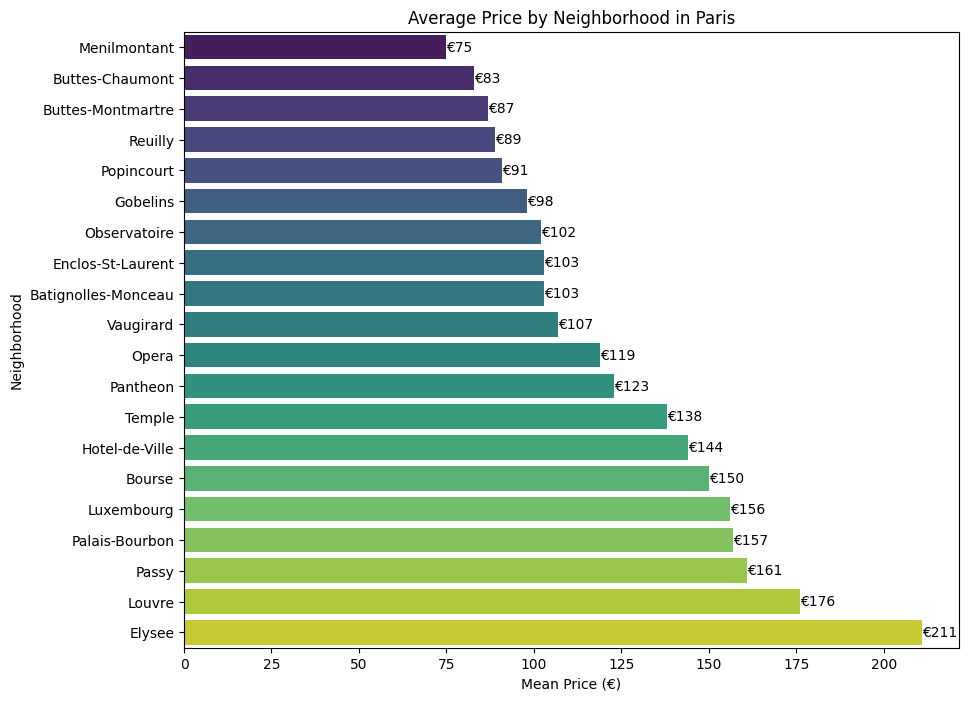

In [41]:
# Create a horizontal bar chart of the average price by neighborhood in Paris

plt.figure(figsize=(10, 8))
sns.barplot(x='mean_price', y='neighbourhood' , data=paris_listings_neighbourhood, palette='viridis')

# Adding annotations for the exact average price at the end of each bar
for index, row in paris_listings_neighbourhood.iterrows():
    plt.text(row['mean_price'], index, f"€{int(row['mean_price'])}", va='center')
    
plt.xlabel('Mean Price (€)')
plt.ylabel('Neighborhood')
plt.title('Average Price by Neighborhood in Paris')
plt.show()

## The average price by accommodates in Paris’ most expensive neighborhood

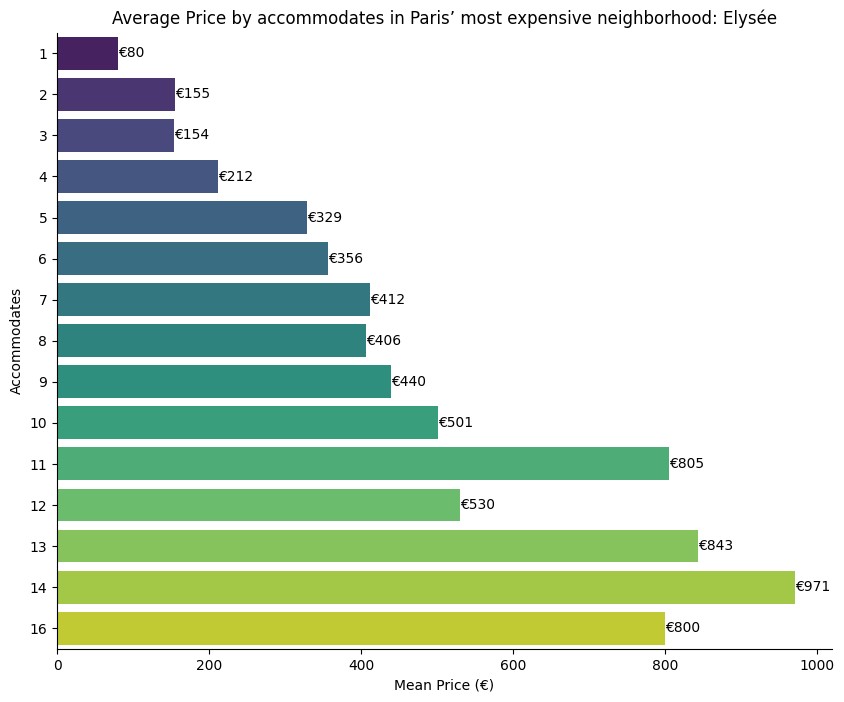

In [42]:
# Create a horizontal bar chart of the average price by ‘accommodates’ in Paris’ most expensive neighborhood: Elysée

plt.figure(figsize=(10, 8))
sns.barplot(x='mean_price', y='accommodates', data=paris_listings_accomodations, palette='viridis', orient='h')

# Adding annotations for the exact average price at the end of each bar
for index, row in paris_listings_accomodations.iterrows():
    plt.text(row['mean_price'], index, f"€{int(row['mean_price'])}", va='center')
    
plt.xlabel('Mean Price (€)')
plt.ylabel('Accommodates')
plt.title('Average Price by accommodates in Paris’ most expensive neighborhood: Elysée')
sns.despine()
plt.show()

## New hosts and average price over time

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

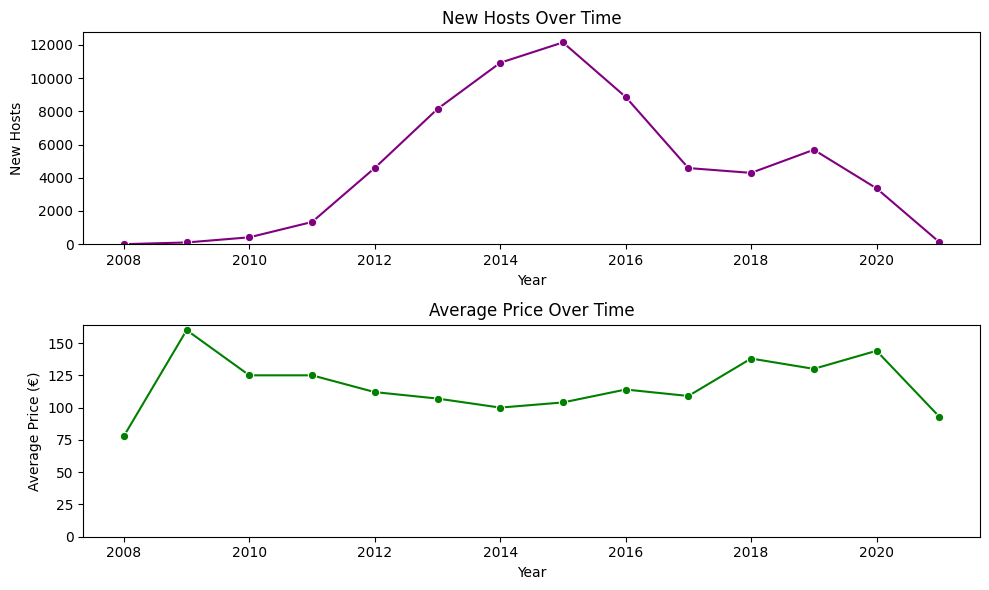

In [43]:
# Create a two line charts for New hosts and average price over time

plt.figure(figsize=(10, 6))

# Line chart for count of new hosts over time
plt.subplot(2, 1, 1)  # Subplot 1 for count of new hosts
sns.lineplot(x='year', y='new_hosts', data=paris_listings_over_time, marker='o', color='purple')
plt.title('New Hosts Over Time')
plt.xlabel('Year')
plt.ylabel('New Hosts')
plt.ylim(0)  # Set y-axis limit to 0

# Line chart for average price over time
plt.subplot(2, 1, 2)  # Subplot 2 for average price
sns.lineplot(x='year', y='mean_price', data=paris_listings_over_time, marker='o', color='green')
plt.title('Average Price Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price (€)')
plt.ylim(0)  # Set y-axis limit to 0

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

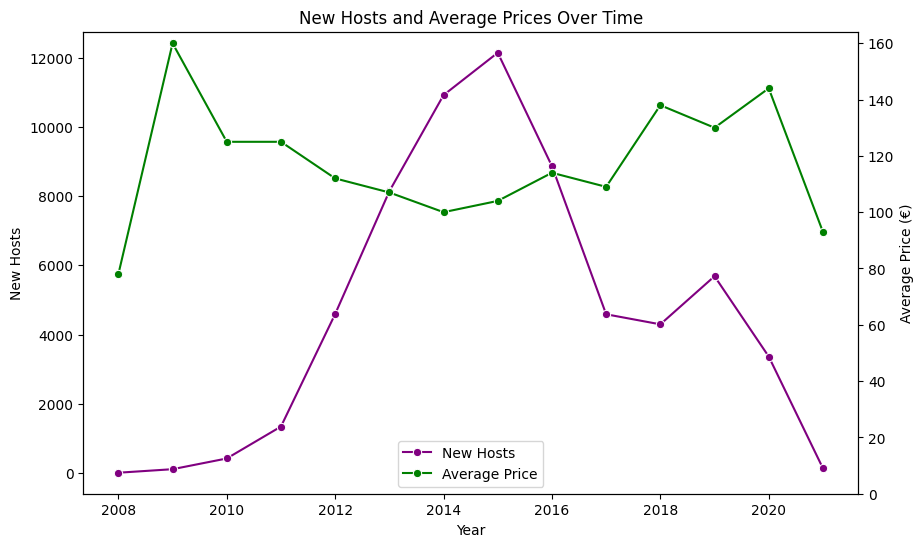

In [45]:
# Combining the two charts

plt.figure(figsize=(10, 6))

# Plot count of new hosts over time
ax1 = sns.lineplot(x='year', y='new_hosts', data=paris_listings_over_time, marker='o', color='purple', label='New Hosts', legend=None)

# Set labels and title for the first axis
ax1.set_xlabel('Year')
ax1.set_ylabel('New Hosts')

# Create a second y-axis for average price
ax2 = ax1.twinx()
sns.lineplot(x='year', y='mean_price', data=paris_listings_over_time, ax=ax2, marker='o', color='green', label='Average Price')

# Set labels and title for the second axis
ax2.set_ylabel('Average Price (€)')
plt.ylim(0)
# Show legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower center')

plt.title('New Hosts and Average Prices Over Time')
plt.show()

> We can observe a decline in the number of new hosts after the implementation of new regulations in France in 2015. Additionally, the average price increased as a consequence of these regulations until the onset of the 2020 pandemic.